In [69]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import struct
from scipy.io import wavfile as wav
import IPython.display as ipd

import tools as tls

import lib_read_wav as wr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Looking at metadata

First of all let's look what the distribution of classes looks like. For this we'll run some stats on train.csv file

In [2]:
meta = pd.read_csv('train.csv')
meta.shape

(9473, 3)

In [3]:
meta.sample(5)

,fname,label,manually_verified
1488,28b75c35.wav,Knock,1
7721,d144542a.wav,Shatter,0
9353,fcb33228.wav,Shatter,0
4663,7e416203.wav,Squeak,0
6650,b5a5bb62.wav,Microwave_oven,0


Let's count various things

In [19]:
meta.fname.value_counts().head(1)

ddb0a078.wav    1
Name: fname, dtype: int64

good. every files happens only once

In [20]:
labels_cnt = meta.label.value_counts()

In [21]:
labels_cnt.shape

(41,)

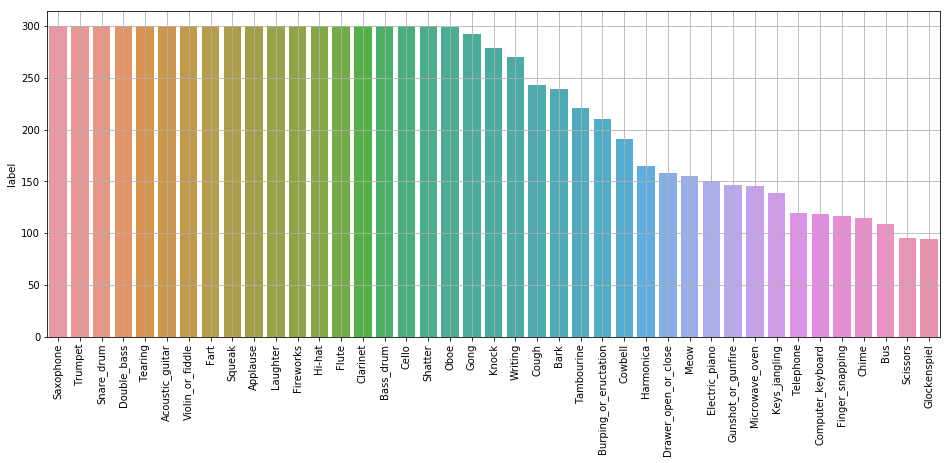

In [22]:
f, ax = plt.subplots(figsize=(16,6))
sns.barplot(x=labels_cnt.index, y=labels_cnt, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.grid(True)

There are 41 labels. About half has 300 samples. The smalles category 'Glockenspiel' and 'Scissors' have a little bit under 100 samples. As for now I'll ignore unbalnce between the classe

In [25]:
meta.manually_verified.value_counts(normalize=True)

0    0.608361
1    0.391639
Name: manually_verified, dtype: float64

60% of the data is manually verified. Let's see if manually verified samples are equally distributed among classes

In [31]:
labels_clean = meta.groupby('label').manually_verified.apply(np.mean).sort_values(ascending=False)

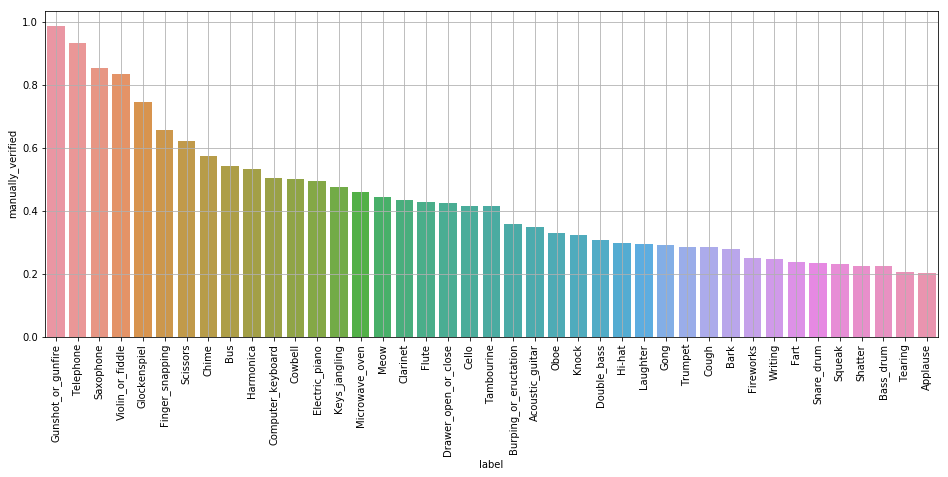

In [32]:
f, ax = plt.subplots(figsize=(16,6))
sns.barplot(x=labels_clean.index, y=labels_clean, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.grid(True)

So this clean labels are distributed among the classes rather unequally. Let's look at the raw counts of labels

In [33]:
clean_only = meta[meta.manually_verified == 1].label.value_counts()

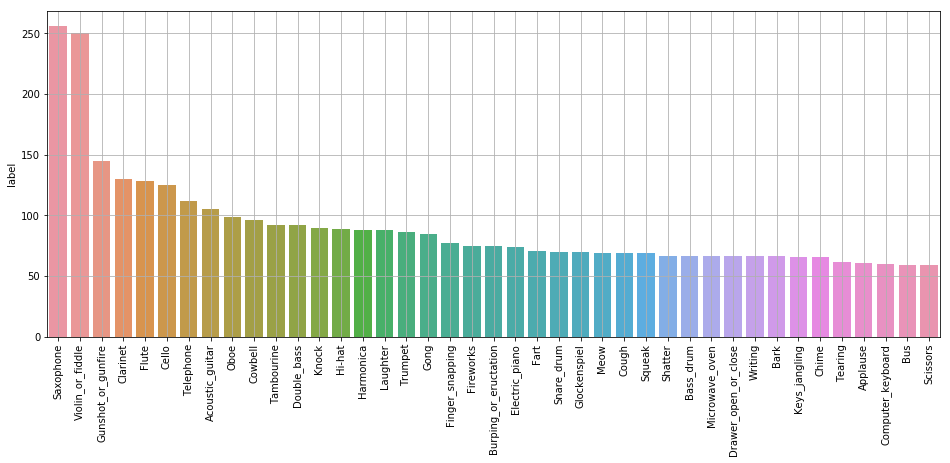

In [34]:
f, ax = plt.subplots(figsize=(16,6))
sns.barplot(x=clean_only.index, y=clean_only, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.grid(True)

Now we have a more balanced distribution, albeit much sadder: lots of the labels have inbetween 50 and 100 samples. A few labels are oversampled

## WAV format

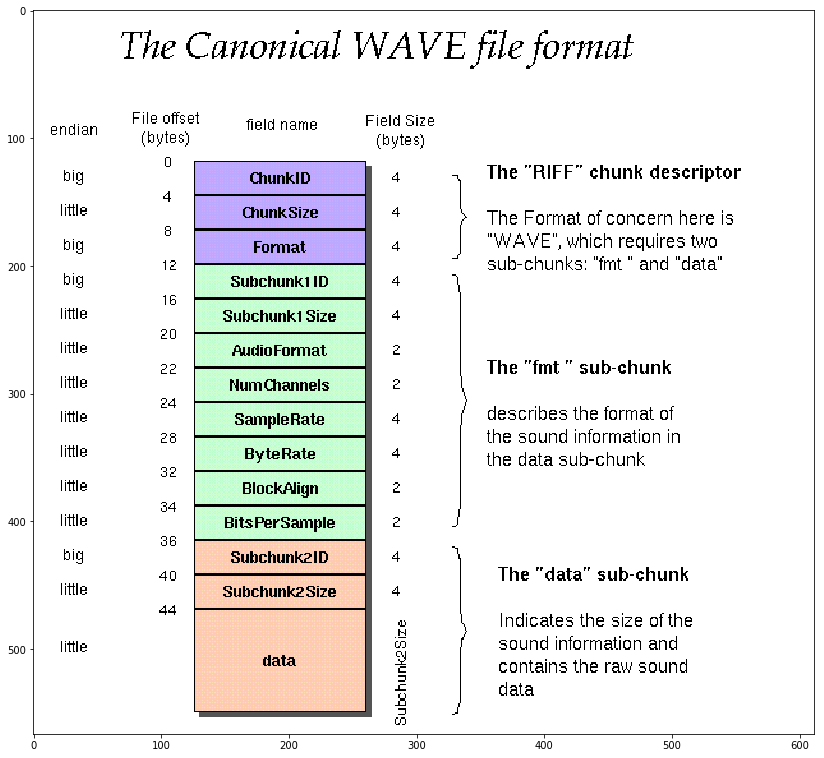

In [58]:
plt.figure(figsize=(14,14))
image = plt.imread('wav-sound-format.gif')
plt.imshow(image)

In order to digitize sound, on has to sample it. When sampling we take measurement of the amplitude of the sound once in dt. 1/dt is called sampling rate. Duriation of the file T multiplied by sampling rate will give us 'length of the vector' with which we represent the file. There are certain limitations on how small sampling rate can be: the Nyquist theorem says that sampling rate must be at least 2x more than maximum frequency we want to hear. 

Even if the files have the same sampling rate, the duration of the files varies and we'll get different lengths of vectors (outputs of sampling).

There's a chance that bit depth and number of channels vary too.

In order to extract information about number of channels, sampling rate and bit depth we used WAV format specs

## WAV visualizations

38f5a8df.wav
Label: Knock
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


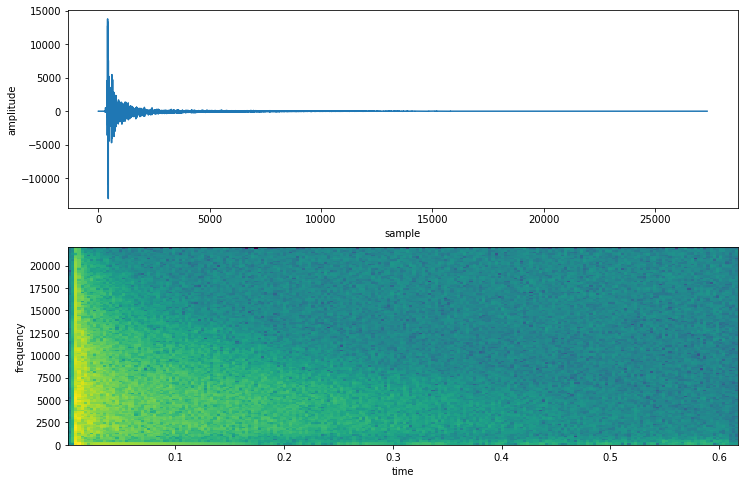

In [124]:
wr.wav_plotter(meta, '38f5a8df.wav')

ac747df0.wav
Label: Squeak
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


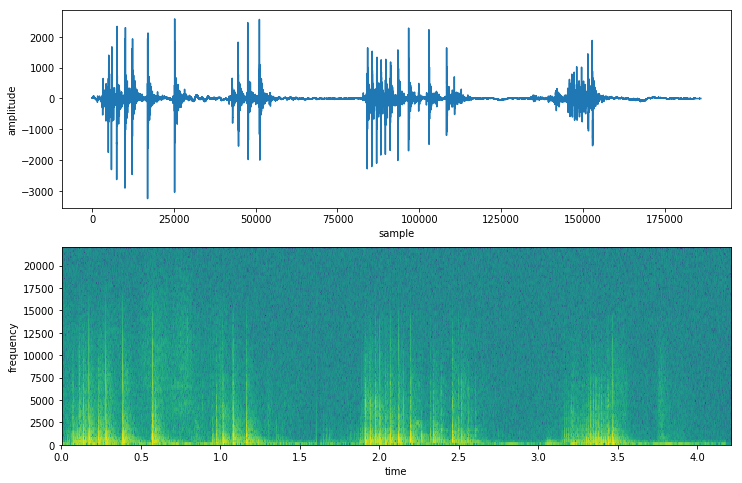

In [125]:
wr.wav_plotter(meta, 'ac747df0.wav')

c81bd883.wav
Label: Flute
Number of channels: 1
Sampling rate: 44100
Bit depth: 16


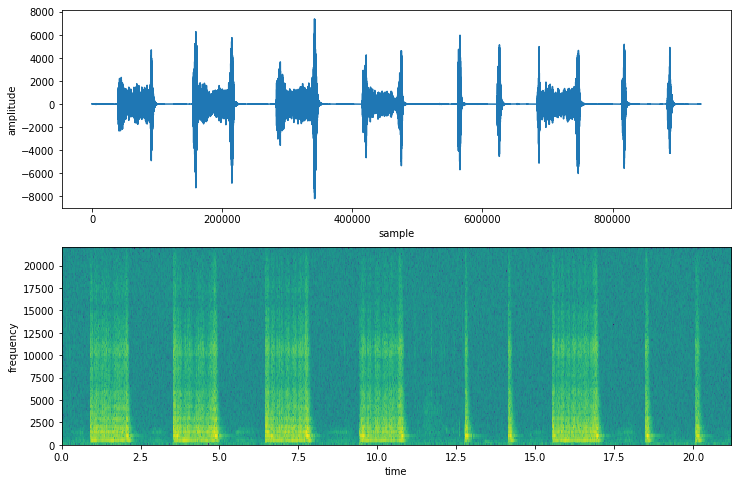

In [141]:
wr.wav_plotter(meta, 'c81bd883.wav')

In [87]:
fmt_data = wr.read_fmt_data(meta)

In [88]:
fmt_data.n_chan.value_counts()

1    9473
Name: n_chan, dtype: int64

All files have the same number of chanels

In [89]:
fmt_data.s_freq.value_counts()

44100    9473
Name: s_freq, dtype: int64

And the same sampling frequency

In [90]:
fmt_data.bit_depth.value_counts()

16    9473
Name: bit_depth, dtype: int64

And the same bit depth. Thus leaving us with the problem of unequal lengths of the sampled sounds.

And as figures below show, lengths are distributed all over the place

/Users/eliza/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 30)

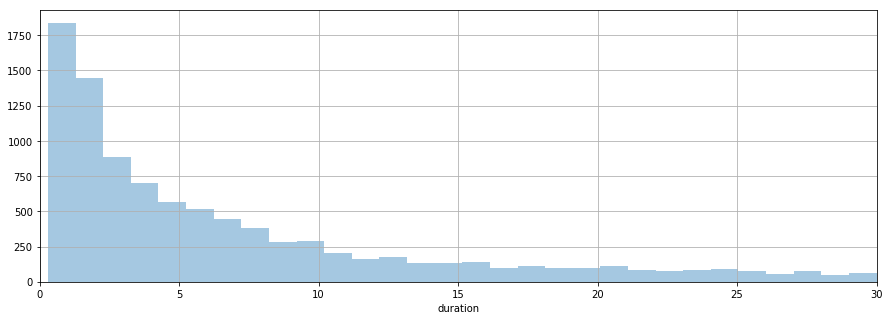

In [140]:
plt.figure(figsize=(15,5))
sns.distplot(fmt_data.n_samples.apply(lambda x: x/44100).rename('duration'),bins=30,kde=False)
plt.grid()
plt.xlim(0,30)

In [96]:
meta_n_fmt = pd.concat([meta, fmt_data], axis=1)

Event within the same class

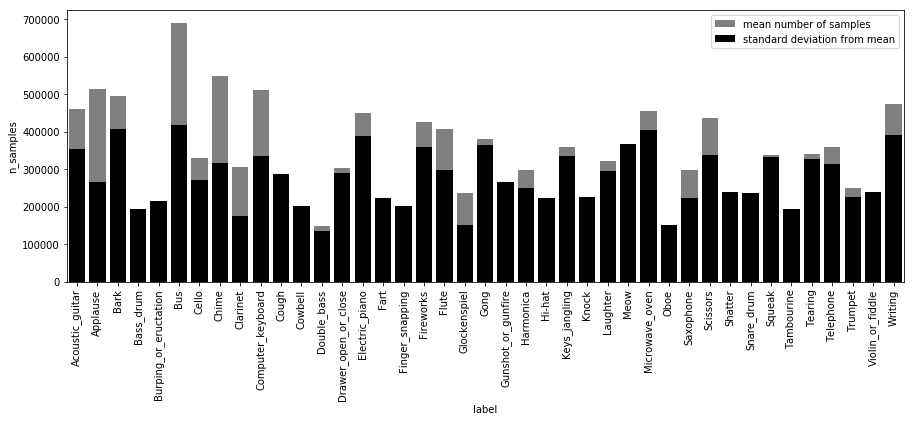

In [110]:
f, ax = plt.subplots(figsize=(15,5))
stds = meta_n_fmt.groupby('label').n_samples.apply(np.std)
means = meta_n_fmt.groupby('label').n_samples.apply(np.mean)
sns.barplot(x=means.index, y=means, color='grey', ax=ax, label='mean number of samples')
sns.barplot(x=stds.index, y=stds, color='k', ax=ax, label='standard deviation from mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
#plt.grid(True)
plt.legend()

OK. This dataset is quite a mess. I will choose three sounds: two sorta similar and one very distinctive, such as Oboe, Clarinet (both woodwind instroments) and meow (cuz, duh, cats).

## Proceed to sandbox.ipynb